In [51]:
from pathlib import Path

from lifelines.datasets import load_lung
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test
import pandas as pd

In [52]:
df = load_lung()

In [53]:
def split_by_fractions(df: pd.DataFrame, fracs: list, random_state: int):
    df = df.sample(frac=1.0, random_state=random_state)
    assert sum(fracs) == 1.0, 'fractions sum is not 1.0 (fractions_sum={})'.format(sum(fracs))
    remain = df.index.copy().to_frame()
    res = []
    for i in range(len(fracs)):
        fractions_sum = sum(fracs[i:])
        frac = fracs[i] / fractions_sum
        idxs = remain.sample(frac=frac, random_state=random_state).index
        remain = remain.drop(idxs)
        res.append(idxs)
    return [df.loc[idxs] for idxs in res]

c, p1, p2, p3, p4 = split_by_fractions(df, fracs=[0.1, 0.15, 0.15, 0.3, 0.3], random_state=42)
display(c)
clients = [c, p1, p2, p3, p4]
for n_client in range(1, 6):
    Path(f'5_clients/client_{n_client}').mkdir(parents=True, exist_ok=True)
    clients[n_client-1].to_csv(f'5_clients/client_{n_client}/data.csv', index=False)

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
74,21.0,226,1,53,2,1.0,90.0,80.0,825.0,3.0
153,16.0,182,1,53,2,1.0,80.0,60.0,NaN,4.0
126,7.0,92,1,50,1,1.0,80.0,60.0,1075.0,13.0
191,16.0,81,1,52,1,2.0,60.0,70.0,1075.0,NaN
137,13.0,387,1,56,1,2.0,80.0,60.0,1075.0,NaN
160,32.0,384,0,62,2,0.0,90.0,90.0,588.0,8.0
18,1.0,61,1,56,2,2.0,60.0,60.0,238.0,10.0
48,13.0,643,1,74,1,0.0,90.0,90.0,1425.0,2.0
203,3.0,202,0,50,2,0.0,100.0,100.0,635.0,1.0
219,2.0,175,0,57,2,0.0,80.0,80.0,725.0,11.0


,test_statistic,p,-log2(p)
0,10.326742,0.001311,9.574936


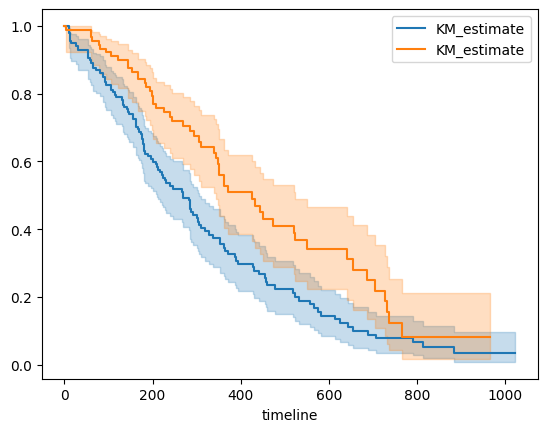

In [54]:
male = df[df['sex'] == 1]
female = df[df['sex'] == 2]
ax = plt.subplot(111)
km1 = KaplanMeierFitter()
km2 = KaplanMeierFitter()
km1.fit(male['time'], event_observed=male['status'])
km2.fit(female['time'], event_observed=female['status'])
km1.plot_survival_function(ax=ax)
km2.plot_survival_function(ax=ax)
results = logrank_test(male['time'], female['time'], event_observed_A=male['status'], event_observed_B=female['status'])


In [63]:
fed = pd.read_csv('5_clients/fc_kaplan_meier/client_1/logrank_test.csv', index_col=0).drop(['Category 1', 'Category 2', 'log(p)'], axis=1)
fed.index = ['5 clients']
fed

,test_statistic,p
5 clients,10.326742,0.001311


In [66]:
central = results.summary.drop('-log2(p)', axis=1)
central.index = ['central']
central

,test_statistic,p
central,10.326742,0.001311


In [71]:
results = pd.concat([fed, central])

In [72]:
results

,test_statistic,p
5 clients,10.326742,0.001311
central,10.326742,0.001311
